<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Deep_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y activar high-RAM**

In [9]:
# Montar Drive
from google import colab
colab.drive.mount('/content/drive')

# Configurar GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Activar high-RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Sep  2 20:17:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   50C    P0             28W /   72W |    1041MiB /  23034MiB |      0%      Default |
|          

# **Deep_Clustering: carga NPZ + AE + K-sweep + DEC (+ IDEC)**
* Este notebook consumirá los NPZ generados por "Scalograms".
* Optimizaciones: GPU, AMP (mixed precision), prefetch, pin_memory.


## **0. Preeliminares**

In [10]:
# ============================================================
#  PRELIMINARES: Parámetros + Imports + Runtime/Device + Utils
# ============================================================

# -----------------------------
# PARÁMETROS (ajusta solo esta sección)
# -----------------------------
BASE_DIR           = "/content/drive/MyDrive/Deep_Cluster"
EXPERIMENTS_DIR    = f"{BASE_DIR}/experiments"

# Carga de datos
PRELOAD_DATA       = True
PRELOAD_MAX_GB     = 4.0
IMG_NORMALIZE_AGAIN= False

# DataLoader
BATCH_AE           = 64
BATCH_EMB          = 128
BATCH_DEC          = 64
NUM_WORKERS        = 2
PIN_MEMORY         = True
PERSISTENT_WORKERS = True

# Modelo / Entrenamiento
IMG_SIZE           = (256, 256)
LATENT_DIM         = 128
BACKBONE           = "base"      # 'small' | 'base' | 'large'
DROPOUT_P          = 0.0

AE_EPOCHS          = 25
AE_LR              = 1e-3
AE_WD              = 1e-5
AE_LOSS            = "l1"
USE_AMP            = True

# K auto
K_MIN              = 2
K_MAX              = 10
K_FIXED            = None
K_RANDOM_STATE     = 2025

# DEC
DEC_EPOCHS         = 40
DEC_LR             = 1e-4
DEC_WD             = 0.0
DEC_UPDATE_INT     = 1
DEC_TOL            = 1e-3

# IDEC (opcional)
RUN_IDEC           = False
IDEC_EPOCHS        = 40
IDEC_LR            = 1e-4
IDEC_WD            = 0.0
IDEC_LAMBDA_REC    = 1e-2
IDEC_UPDATE_INT    = 1
IDEC_TOL           = 1e-3

# Visualización / Guardado
RUN_TSNE_2D        = True
TSNE_PERPLEXITY    = 30
SEED               = 2025
SAVE_ARTIFACTS     = True

# -----------------------------
# IMPORTS
# -----------------------------
import os, time, csv, math, gc, json, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

from datetime import datetime
from collections import defaultdict, Counter

# 👉 IMPORTANTE: tqdm (no 'auto' para evitar widgets en GitHub)
from tqdm import tqdm

# -----------------------------
# Runtime / Device
# -----------------------------
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Dispositivo:", torch.cuda.get_device_name(0) if DEVICE.type=="cuda" else "CPU")

os.makedirs(EXPERIMENTS_DIR, exist_ok=True)
RUN_DIR = os.path.join(EXPERIMENTS_DIR, datetime.now().strftime("run_%Y%m%d_%H%M%S"))
os.makedirs(RUN_DIR, exist_ok=True)
print("Carpeta de ejecución:", RUN_DIR)

# -----------------------------
# Utils
# -----------------------------
def sizeof_gb(n_items, h, w, bytes_per=2):
    return (n_items * h * w * bytes_per) / (1024**3)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


✅ Dispositivo: NVIDIA L4
Carpeta de ejecución: /content/drive/MyDrive/Deep_Cluster/experiments/run_20250902_201700


## **1) Conjunto de datos**

[SCAN] .npz encontrados: 29
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_000.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_001.npz
  • /content/drive/MyDrive/Deep_Cluster/data/scalos_train_002.npz
  • …
[MANIFEST] Ventanas=1800 | HxW=256x256
[MEM] ~0.22 GB | Preload=True (umbral=4.0 GB)
[LOAD] Precargando .npz a RAM…


Precarga: 100%|██████████| 29/29 [00:01<00:00, 15.00it/s]


[DATA] Train=1440 | Val=360 | Total=1800 | HxW=256x256


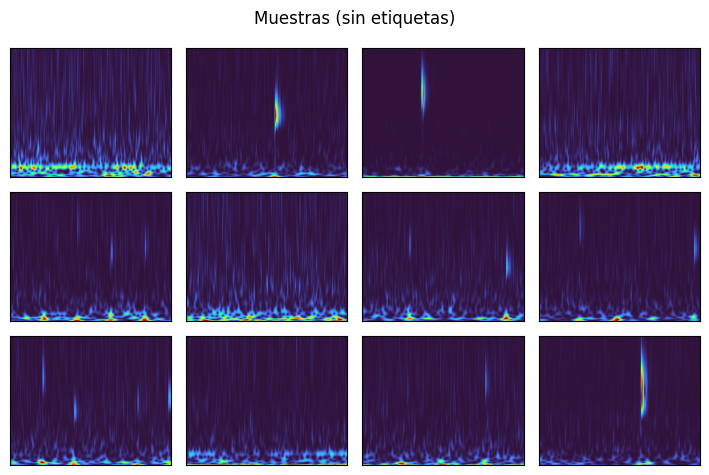

In [14]:
# ============================================================
# 1) DATASET (no supervisado): descubre .npz y carga escalogramas
# ============================================================
import glob
import bisect
from torch.utils.data import Subset, DataLoader

DATA_DIR = os.path.join(BASE_DIR, "data")
npz_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.npz")))
if not npz_files:
    raise FileNotFoundError(f"No hay .npz en {DATA_DIR}. ¿Ya corriste 'Scalograms'?")

print(f"[SCAN] .npz encontrados: {len(npz_files)}")
for p in npz_files[:3]: print("  •", p)
if len(npz_files) > 3: print("  • …")

class NPZManifest:
    def __init__(self, files):
        self.files = list(files)
        self.counts, self.cumcounts = [], [0]
        self.img_h = None; self.img_w = None
        for p in self.files:
            d = np.load(p, allow_pickle=True)
            X = d["X"]  # (B,H,W)
            B, H, W = X.shape
            self.counts.append(B)
            self.cumcounts.append(self.cumcounts[-1] + B)
            if self.img_h is None:
                self.img_h, self.img_w = int(H), int(W)
            else:
                if (self.img_h, self.img_w) != (int(H), int(W)):
                    raise ValueError(f"Tamaños inconsistentes: {p} tiene {(H,W)} vs {(self.img_h,self.img_w)}")
        self.total = self.cumcounts[-1]

    def __len__(self): return self.total

    def locate(self, global_idx):
        # usa bisect para encontrar el bloque
        file_idx = bisect.bisect_right(self.cumcounts, global_idx) - 1
        local_idx = global_idx - self.cumcounts[file_idx]
        return self.files[file_idx], int(local_idx)

manifest = NPZManifest(npz_files)
print(f"[MANIFEST] Ventanas={len(manifest)} | HxW={manifest.img_h}x{manifest.img_w}")

# Estima si conviene precargar
est_gb = sizeof_gb(len(manifest), manifest.img_h, manifest.img_w, bytes_per=2)  # float16
do_preload = PRELOAD_DATA and (est_gb <= PRELOAD_MAX_GB + 1e-9)
print(f"[MEM] ~{est_gb:.2f} GB | Preload={do_preload} (umbral={PRELOAD_MAX_GB} GB)")

class ScalogramUnsupervisedDS(Dataset):
    """Devuelve (x, '_') con x -> tensor (1,H,W) en [0,1]."""
    def __init__(self, manifest: NPZManifest, preload=False, normalize_again=False):
        self.manifest = manifest
        self.normalize_again = normalize_again
        self.preload = preload
        self.cache = {}
        if self.preload:
            print("[LOAD] Precargando .npz a RAM…")
            for p in tqdm(self.manifest.files, desc="Precarga"):
                self.cache[p] = np.load(p, allow_pickle=True)["X"]  # (B,H,W) float16

    def __len__(self): return len(self.manifest)

    def __getitem__(self, i):
        p, j = self.manifest.locate(i)
        Xj = self.cache[p][j] if p in self.cache else np.load(p, allow_pickle=True)["X"][j]
        x = torch.from_numpy(np.asarray(Xj, dtype=np.float32)).unsqueeze(0)  # (1,H,W)
        if IMG_NORMALIZE_AGAIN:
            mn, mx = x.min(), x.max()
            x = (x - mn) / (mx - mn + 1e-12)
            x.clamp_(0.0, 1.0)
        return x, "_"  # placeholder sin etiquetas reales

# Instancia dataset y splits 80/20
ds_all = ScalogramUnsupervisedDS(manifest, preload=do_preload, normalize_again=IMG_NORMALIZE_AGAIN)
rng = np.random.default_rng(SEED)
perm = rng.permutation(len(ds_all))
n_tr = int(0.8*len(ds_all))
idx_tr, idx_va = perm[:n_tr], perm[n_tr:]

from torch.utils.data import Subset
ds_train = Subset(ds_all, idx_tr)
ds_val   = Subset(ds_all, idx_va)

# DataLoaders
dl_train = DataLoader(
    ds_train, batch_size=BATCH_AE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
    drop_last=False
)
dl_val = DataLoader(
    ds_val, batch_size=BATCH_AE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
    drop_last=False
)
def make_all_loader(ds, bs=BATCH_EMB):
    return DataLoader(
        ds, batch_size=bs, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS>0 and PERSISTENT_WORKERS),
        drop_last=False
    )
dl_all = make_all_loader(ds_all, bs=BATCH_EMB)

print(f"[DATA] Train={len(ds_train)} | Val={len(ds_val)} | Total={len(ds_all)} | HxW={manifest.img_h}x{manifest.img_w}")

# Vista rápida (opcional)
def show_grid_samples(dataset, n=12, rows=3, cols=4, title="Muestras (sin etiquetas)"):
    n = min(n, len(dataset), rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.6*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)
    idxs = rng.choice(len(dataset), size=n, replace=False)
    for k, i in enumerate(idxs):
        x, _ = dataset[i]
        axes[k].imshow(x.squeeze(0).numpy(), origin="lower", aspect="auto", cmap="turbo")
        axes[k].set_xticks([]); axes[k].set_yticks([])
    for a in axes[n:]: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()

show_grid_samples(ds_all, n=12, rows=3, cols=4)


## **2) Modelo Autoencoder + Capa de Clustering**

In [15]:
# ============================================================
# 2) MODELO: Autoencoder conv (encoder/decoder) + ClusteringLayer
#     - Tres tamaños de backbone: 'small' | 'base' | 'large'
#     - Cálculo automático de tamaños internos según HxW reales
# ============================================================

import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Helpers de arquitectura
# -----------------------------
def make_channels(backbone: str):
    """Devuelve lista de canales por bloque según el tamaño elegido."""
    if backbone == "small":
        return [32, 64, 128, 256]
    if backbone == "large":
        return [64, 128, 256, 512]
    return [32, 64, 128, 256]  # 'base' (por defecto)

def conv_block(in_c, out_c, k=3, s=2, p=1):
    """Bloque conv estándar: Conv2d -> BN -> ReLU, con stride=2 para reducir resolución."""
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )

def deconv_block(in_c, out_c, k=4, s=2, p=1):
    """Bloque deconv: ConvTranspose2d -> BN -> ReLU, duplica resolución espacial."""
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )

# -----------------------------
# Encoder / Decoder / AE
# -----------------------------
class ConvEncoder(nn.Module):
    def __init__(self, in_ch=1, latent_dim=128, dropout_p=0.0, backbone="base", in_size=(256,256)):
        super().__init__()
        self.C = make_channels(backbone)
        self.conv = nn.Sequential(
            conv_block(in_ch,      self.C[0]),  # /2
            conv_block(self.C[0],  self.C[1]),  # /4
            conv_block(self.C[1],  self.C[2]),  # /8
            conv_block(self.C[2],  self.C[3]),  # /16
            nn.Dropout2d(p=dropout_p)
        )
        # Calcula el tamaño aplanado con un forward "dummy" para este HxW
        H, W = in_size
        with torch.no_grad():
            _x = torch.zeros(1, 1, H, W)
            _h = self.conv(_x)
            _, C3, Hs, Ws = _h.shape
        self._enc_out_shape = (self.C[3], Hs, Ws)
        self.flatten_dim = self.C[3] * Hs * Ws
        self.fc = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        h = self.conv(x)                   # (B, C3, Hs, Ws)
        z = self.fc(h.flatten(1))          # (B, L)
        return z

class ConvDecoder(nn.Module):
    def __init__(self, out_ch=1, latent_dim=128, dropout_p=0.0, backbone="base", enc_out_shape=(256,16,16), out_size=(256,256)):
        super().__init__()
        self.C = make_channels(backbone)
        C3, Hs, Ws = enc_out_shape
        self.fc = nn.Linear(latent_dim, C3 * Hs * Ws)
        self.deconv = nn.Sequential(
            deconv_block(self.C[3], self.C[2]),  # x2
            deconv_block(self.C[2], self.C[1]),  # x4
            deconv_block(self.C[1], self.C[0]),  # x8
            nn.ConvTranspose2d(self.C[0], out_ch, kernel_size=4, stride=2, padding=1),  # x16
            nn.Sigmoid()  # salida en [0,1], igual que tus escalogramas normalizados
        )
        self.out_size = out_size  # (H, W) objetivo

    def forward(self, z):
        B = z.size(0)
        C3, Hs, Ws = self._enc_out_shape  # definido por set_enc_shape()
        h = self.fc(z).view(B, C3, Hs, Ws)
        x_rec = self.deconv(h)
        # Ajuste fino por si el múltiplo de /16 no cae exacto
        if x_rec.shape[-2:] != self.out_size:
            x_rec = F.interpolate(x_rec, size=self.out_size, mode="bilinear", align_corners=False)
        return x_rec

    def set_enc_shape(self, enc_out_shape):
        """Informa al decoder el shape del encoder (C3,Hs,Ws). Debe llamarse tras crear el encoder."""
        self._enc_out_shape = enc_out_shape

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, dropout_p=0.0, backbone="base", in_size=(256,256)):
        super().__init__()
        self.encoder = ConvEncoder(in_ch=1, latent_dim=latent_dim, dropout_p=dropout_p, backbone=backbone, in_size=in_size)
        self.decoder = ConvDecoder(out_ch=1, latent_dim=latent_dim, dropout_p=dropout_p, backbone=backbone,
                                   enc_out_shape=self.encoder._enc_out_shape, out_size=in_size)
        self.decoder.set_enc_shape(self.encoder._enc_out_shape)

    def forward(self, x):
        z = self.encoder(x)
        xr = self.decoder(z)
        return z, xr

# -----------------------------
# Capa de Clustering (DEC)
# -----------------------------
class ClusteringLayer(nn.Module):
    """
    Capa de clustering con kernel t-Student (como en DEC).
    - n_clusters: número de centros
    - alpha: parámetro del kernel t-Student
    """
    def __init__(self, n_clusters, latent_dim, alpha=1.0):
        super().__init__()
        self.n_clusters = int(n_clusters)
        self.alpha = float(alpha)
        self.cluster_centers = nn.Parameter(torch.randn(self.n_clusters, latent_dim))

    @torch.no_grad()
    def set_centers(self, centers_np):
        """Inicializa los centros desde KMeans (numpy array KxL)."""
        self.cluster_centers.copy_(torch.as_tensor(centers_np, dtype=torch.float32))

    def forward(self, z):
        # Distancia cuadrática a cada centro
        z_exp  = z.unsqueeze(1)                        # (B,1,L)
        mu_exp = self.cluster_centers.unsqueeze(0)     # (1,K,L)
        dist_sq = torch.sum((z_exp - mu_exp)**2, dim=2)  # (B,K)
        # t-Student
        num = (1.0 + dist_sq / self.alpha) ** (-(self.alpha + 1.0)/2.0)
        q = num / torch.sum(num, dim=1, keepdim=True)     # asignaciones suaves
        return q

# -----------------------------
# Instanciación del AE y capa de clustering
# -----------------------------
in_size = (manifest.img_h, manifest.img_w)  # Tamaño real desde la Celda 1
ae = ConvAutoencoder(latent_dim=LATENT_DIM, dropout_p=DROPOUT_P, backbone=BACKBONE, in_size=in_size).to(DEVICE)

# ClusteringLayer se instanciará más adelante con K óptimo; por ahora un placeholder (K_MIN)
cluster_layer = ClusteringLayer(n_clusters=max(2, K_MIN), latent_dim=LATENT_DIM, alpha=1.0).to(DEVICE)

print(f"[MODEL] AE params: {count_params(ae):,} | Clustering params: {count_params(cluster_layer):,}")
print("Encoder out shape:", ae.encoder._enc_out_shape, "| Imagen:", in_size)

# -----------------------------
# Sanity check rápido (opcional)
# -----------------------------
try:
    xb, _ = next(iter(dl_train))
    xb = xb.to(DEVICE, non_blocking=True)
    with torch.no_grad():
        z, xr = ae(xb[:2])  # mini batch
    print("Sanity OK → z:", z.shape, " xr:", xr.shape)
except Exception as e:
    print("Sanity check: no se pudo probar un forward ahora.", e)


[MODEL] AE params: 17,920,289 | Clustering params: 256
Encoder out shape: (256, 16, 16) | Imagen: (256, 256)
Sanity OK → z: torch.Size([2, 128])  xr: torch.Size([2, 1, 256, 256])
